This notebook is part of the final project for Laura Brooks 501146410 in CIND 820

Notebook will be used to evaluate Airbnb data

Import Packages

In [1]:
pip install geopy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sb

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from geopy.distance import great_circle
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import RFE

Read CSV

In [3]:

#https://public.opendatasoft.com/explore/dataset/airbnb-listings/table/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features

df = pd.read_json('airbnb-listings.json')


In [4]:
pd.set_option('display.max_columns', None) #required to show all columns when using head()
pd.set_option('display.max_rows', None)

In [5]:
print("rows:",df.shape[0]) #display number of rows in entire dataset
print("columns:",df.shape[1]) #display number of cols in entire dataset


rows: 494954
columns: 89


In [6]:
#Keep only Toronto in dataset
dfTor = df.loc[df['city'] == 'Toronto'] 

#Drop all columns where number of reviews are zero as it does not show if the listing performs well or not and would not indicate a good representation for price
dfTor = dfTor.loc[dfTor['number_of_reviews'] != 0]
dfTor = dfTor.reset_index(drop=True)

print("rows:",dfTor.shape[0]) #display number of rows in reduced dataset
print("columns:",dfTor.shape[1]) #display number of cols in reduced dataset

dfTor.head()

rows: 9831
columns: 89


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,cancellation_policy,calculated_host_listings_count,reviews_per_month,geolocation,features
0,17016247,https://www.airbnb.com/rooms/17016247,20170603080828,2017-06-03,2BR in trendy FASHION DISTRICT,My place is located in a very centrally and co...,None,My place is located in a very centrally and co...,none,None,None,None,None,None,None,https://a0.muscache.com/im/pictures/cc957c1d-9...,https://a0.muscache.com/im/pictures/cc957c1d-9...,"{'thumbnail': True, 'filename': 'cc957c1d-99b1...",https://a0.muscache.com/im/pictures/cc957c1d-9...,86295816,https://www.airbnb.com/users/show/86295816,Sofia,2016-07-27,CA,None,within an hour,100.0,None,https://a0.muscache.com/im/pictures/8e094252-5...,https://a0.muscache.com/im/pictures/8e094252-5...,Entertainment District,9.0,9.0,"[email, phone, reviews]","Toronto, ON M6J, Canada",None,Niagara,None,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.646031,-79.404524,Condominium,Entire home/apt,5.0,2.0,2.0,2.0,Real Bed,"[TV, Cable TV, Internet, Wireless Internet, Ai...",NaN,178.0,NaN,NaN,400.0,75.0,3.0,20.0,3.0,60.0,a week ago,None,5.0,16.0,39.0,39.0,2017-06-03,10.0,2017-02-20,2017-05-07,92.0,9.0,10.0,9.0,9.0,9.0,9.0,None,None,strict,9.0,2.88,"{'lon': -79.40452446292299, 'lat': 43.64603146...",[Host Has Profile Pic]
1,3423261,https://www.airbnb.com/rooms/3423261,20170603080828,2017-06-03,GORGEOUS DOWNTOWN KING WEST LOFT,My chic and modern one bedroom apartment is ri...,"Spacious, open concept loft. Includes laundry,...",My chic and modern one bedroom apartment is ri...,none,The King West neighborhood is the most popular...,None,There is transit at the doorstep of the buildi...,"Gym in the building, as well as parking if des...",None,None,None,None,"{'thumbnail': True, 'filename': '45ec4921_orig...",None,15064659,https://www.airbnb.com/users/show/15064659,Devin,2014-05-03,"Toronto, Ontario, Canada",Young working professional determined to see a...,within a day,100.0,None,https://a0.muscache.com/im/pictures/07c2bfe0-6...,https://a0.muscache.com/im/pictures/07c2bfe0-6...,Niagara,1.0,1.0,"[email, phone, reviews, jumio]","Niagara, Toronto, ON M6K 0A1, Canada",Niagara,Niagara,None,Toronto,ON,M6K 0A1,Toronto,"Toronto, Canada",CA,Canada,43.641340,-79.413251,Loft,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"[TV, Internet, Wireless Internet, Air conditio...",NaN,69.0,NaN,1990.0,NaN,99.0,1.0,0.0,1.0,1125.0,yesterday,None,3.0,3.0,3.0,3.0,2017-06-03,13.0,2014-09-01,2016-11-27,76.0,6.0,8.0,9.0,8.0,9.0,9.0,None,None,flexible,1.0,0.39,"{'lon': -79.41325061425616, 'lat': 43.64134046...","[Host Has Profile Pic, Host Identity Verified,..."
2,5287507,https://www.airbnb.com/rooms/5287507,20170603080828,2017-06-03,Chic 2 Storey loft- Liberty Village,"Located in the heart of Liberty Village, my fu...",Located in Downtown Toronto this loft boats st...,"Located in the he

Drop Columns Not Contextually Relevant

In [7]:
#Drop ID columns

droppedCols = []

idCols = ["id","scrape_id","host_id"]
droppedCols.extend(idCols)
dfTor = dfTor.drop(idCols, axis=1)

#Drop columns containing URLS

URLCols = ["listing_url","thumbnail_url","medium_url","picture_url","xl_picture_url","host_url","host_thumbnail_url","host_picture_url"]
droppedCols.extend(URLCols)
dfTor = dfTor.drop(URLCols, axis=1)


Drop Columns that will not provide value

In [8]:
#Look to see if columns are null

fullNaN = []
majorityNaN = []

for col in dfTor.columns:
    nan_count = dfTor[col].isna().sum() #get number of null values
    percentNaN = nan_count/dfTor.shape[0]*100 #get percentage of null values
    if percentNaN == 100: #fully null
        fullNaN.append(col)
    elif percentNaN >= 60: #mostly null values, will need more investigation
        majorityNaN.append(col)

droppedCols.extend(fullNaN) #drop fully null values     
dfTor = dfTor.drop(fullNaN, axis=1)
droppedCols.extend(majorityNaN) #drop majority null values
dfTor = dfTor.drop(majorityNaN, axis=1)

In [9]:
print(majorityNaN)
print(fullNaN)

['square_feet', 'weekly_price', 'monthly_price']
['host_acceptance_rate', 'neighbourhood_group_cleansed', 'has_availability', 'license', 'jurisdiction_names']


In [10]:
print(droppedCols)

['id', 'scrape_id', 'host_id', 'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_acceptance_rate', 'neighbourhood_group_cleansed', 'has_availability', 'license', 'jurisdiction_names', 'square_feet', 'weekly_price', 'monthly_price']


In [11]:
#Look at different types of columns

colsDict = []
colsList = []
colsNum = []
colsRemaining = []

for col in dfTor.columns:
    if isinstance(dfTor[col][0],dict): #column contains a dictionary
        colsDict.append(col)
    elif isinstance(dfTor[col][0],list): #column contains a list
        colsList.append(col)
    elif dfTor[col].nunique() == 1: #column contains only one value
        #If yes, drop the column
        print("Dropping column:", col, "- Only 1 value in Column")
        dfTor = dfTor.drop(col, axis=1)
        droppedCols.append(col)
    elif dfTor[col].dtype.kind in ['i', 'f']: #column is numeric
         colsNum.append(col)
    else:
        colsRemaining.append(col) #column is none of the above
         
print(dfTor['state'].unique()) #look at the values for these columns and decide whether to keep or drop
print(dfTor['market'].unique())
print(dfTor['smart_location'].unique())

droppedCols.extend(['state','market','smart_location'])
dfTor = dfTor.drop(['state','market','smart_location'], axis=1)

Dropping column: last_scraped - Only 1 value in Column
Dropping column: experiences_offered - Only 1 value in Column
Dropping column: city - Only 1 value in Column
Dropping column: country_code - Only 1 value in Column
Dropping column: country - Only 1 value in Column
Dropping column: calendar_last_scraped - Only 1 value in Column
['ON' 'Ontario' '1' 'On' 'Ont']
['Toronto' None 'Other (International)' 'Paris' 'Montreal' 'Boracay'
 'Barrie']
['Toronto, Canada' 'Toronto , Canada']


In [12]:
#investigate dictionaries
for col in colsDict:
    print(col)
    for i in range(0,3):
        print(dfTor[col].iloc[i])

geolocation
{'lon': -79.40452446292299, 'lat': 43.64603146761254}
{'lon': -79.41325061425616, 'lat': 43.641340461522496}
{'lon': -79.41456998953726, 'lat': 43.63966507804839}


In [13]:
#compare geolocation with longitude and latitude

print(dfTor['geolocation'].iloc[0])
print(dfTor['longitude'].iloc[0])
print(dfTor['latitude'].iloc[0])

#drop geolocation as it is the combination of the longitude and latitude fields

for col in colsDict:
    print("Dropping column:", col, "- Dictionary does not add value")
    dfTor = dfTor.drop(col, axis=1)
    droppedCols.append(col)

{'lon': -79.40452446292299, 'lat': 43.64603146761254}
-79.40452446292299
43.64603146761254
Dropping column: geolocation - Dictionary does not add value


c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


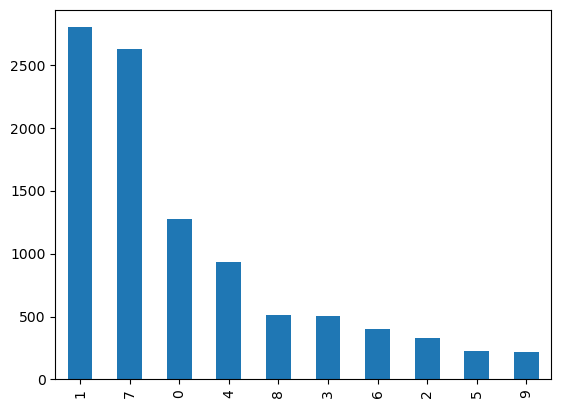

In [14]:
# Function to assign neighborhood labels
def assign_neighborhoods(df, n_neighborhoods):
    # Initialize KMeans model
    kmeans = KMeans(n_clusters=n_neighborhoods)

    # Convert latitude and longitude columns to numpy array
    coords = df[['latitude', 'longitude']].to_numpy()

    # Fit KMeans model
    kmeans.fit(coords)

    # Assign neighborhood labels to each coordinate
    df['neighborhoodNew'] = kmeans.predict(coords)

    return df

# Call the function to assign neighborhood labels
dfTor = assign_neighborhoods(dfTor, n_neighborhoods=10)

# Print the updated DataFrame
dfTor['neighborhoodNew'].value_counts().plot(kind='bar')

droppedCols.extend(["latitude","longitude"])
dfTor = dfTor.drop(["latitude","longitude"], axis=1)

In [15]:
neighbourHoodCols = ["neighbourhood_cleansed","host_neighbourhood"]
droppedCols.extend(neighbourHoodCols)
dfTor = dfTor.drop(neighbourHoodCols, axis=1)

In [16]:
#investigate lists
for col in colsList:
    print(col)

host_verifications
amenities
features


In [17]:
def get_unique_values(column):
    unique_values = []
    for sublist in column:
        if sublist is not None:
            unique_values.extend(sublist)  # Add each value from list to unique_values list
    unique_values = list(dict.fromkeys(unique_values))  # Remove duplicate values by converting to a dictionary and back to a list
    return unique_values

def print_unique_values(name, values):
    print(name + ":", len(values))  # Print the name and the length of the values list
    print(values)  # Print the values list

#Show all values in host_verifications
host_verificationsCL = get_unique_values(dfTor['host_verifications'])
print_unique_values("Host Verifications", host_verificationsCL)

#Show all values in features
featuresCL = get_unique_values(dfTor['features']) 
print_unique_values("Features", featuresCL)

#Show all values in amentities
amenitiesCL = get_unique_values(dfTor['amenities'])  
print_unique_values("Amenities", amenitiesCL) 

Host Verifications: 22
['email', 'phone', 'reviews', 'jumio', 'work_email', 'google', 'offline_government_id', 'government_id', 'facebook', 'linkedin', 'selfie', 'identity_manual', 'manual_offline', 'sent_id', 'kba', 'weibo', 'manual_online', 'photographer', 'None', 'sesame', 'sesame_offline', 'amex']
Features: 7
['Host Has Profile Pic', 'Host Identity Verified', 'Is Location Exact', 'Host Is Superhost', 'Instant Bookable', 'Require Guest Phone Verification', 'Require Guest Profile Picture']
Amenities: 108
['TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air conditioning', 'Kitchen', 'Elevator in building', 'Heating', 'Washer', 'Dryer', 'Smoke detector', 'Carbon monoxide detector', 'Fire extinguisher', 'Essentials', 'Shampoo', 'Lock on bedroom door', 'Hangers', 'Hair dryer', 'Iron', 'Private entrance', 'Free parking on premises', 'Doorman', 'Gym', 'Buzzer/wireless intercom', 'Family/kid friendly', 'Pets allowed', 'Laptop friendly workspace', 'First aid kit', '24-hour check-in', 'Br

In [18]:
#Drop columns containing review details as new listings won't have this information yet

for col in dfTor.columns:
    if "review" in col:
        print("Dropping", col)
        droppedCols.extend([col])
        dfTor = dfTor.drop([col], axis=1)

#Drop host_response_rate because a new host won't have this information
droppedCols.append('host_response_rate')
dfTor = dfTor.drop(['host_response_rate'], axis=1)
droppedCols.append('host_response_time')
dfTor = dfTor.drop(['host_response_time'], axis=1)


Dropping number_of_reviews
Dropping first_review
Dropping last_review
Dropping review_scores_rating
Dropping review_scores_accuracy
Dropping review_scores_cleanliness
Dropping review_scores_checkin
Dropping review_scores_communication
Dropping review_scores_location
Dropping review_scores_value
Dropping reviews_per_month


In [19]:
#Convert free text columns to string length
#If null, length is 0

dfTor['spaceLen'] = np.where(dfTor['space'].isnull(), 0, dfTor['space'].str.len())
dfTor['neighbourhood_overviewLen'] = np.where(dfTor['neighborhood_overview'].isnull(), 0, dfTor['neighborhood_overview'].str.len())
dfTor['summaryLen'] = np.where(dfTor['summary'].isnull(), 0, dfTor['summary'].str.len())
dfTor['descriptionLen'] = np.where(dfTor['description'].isnull(), 0, dfTor['description'].str.len())
dfTor['notesLen'] = np.where(dfTor['notes'].isnull(), 0, dfTor['notes'].str.len())
dfTor['transitLen'] = np.where(dfTor['transit'].isnull(), 0, dfTor['transit'].str.len())
dfTor['accessLen'] = np.where(dfTor['access'].isnull(), 0, dfTor['access'].str.len())
dfTor['interactionLen'] = np.where(dfTor['interaction'].isnull(), 0, dfTor['interaction'].str.len())
dfTor['houseRulesLen'] = np.where(dfTor['house_rules'].isnull(), 0, dfTor['house_rules'].str.len())
dfTor['hostAboutLen'] = np.where(dfTor['host_about'].isnull(), 0, dfTor['host_about'].str.len())
dfTor['nameLen'] = np.where(dfTor['name'].isnull(), 0, dfTor['name'].str.len())

droppedCols.extend(['space','neighborhood_overview','summary','description','notes','transit','access','interaction','house_rules','host_name', 'host_location','host_about','name'])
dfTor = dfTor.drop(['space','neighborhood_overview','summary','description','notes','transit','access','interaction','house_rules','host_name', 'host_location','host_about','name'], axis=1)

In [20]:
#Convert date to number of days since June 17, 2023

basedate = pd.Timestamp('2023-06-17')
dfTor['daysAsHost'] = (basedate - pd.to_datetime(dfTor['host_since'])).dt.days #new hosts will have negative days

droppedCols.extend(['host_since']) 
dfTor = dfTor.drop(['host_since'], axis=1)

In [21]:
droppedCols.extend(['zipcode','neighbourhood']) #zipcode and neighbourhood represented with NeighbourhoodNew
dfTor = dfTor.drop(['zipcode','neighbourhood'], axis=1)

Handle Categorical Values

In [22]:
catCols = ["property_type","room_type","bed_type","cancellation_policy"]
print(len(catCols))
for col in catCols:
    print(col,dfTor[col].nunique()) #Check if column only has one unique value
    if dfTor[col].nunique() <= 20:
        print(dfTor[col].unique()) #If number of categories is under 20, show them
 


4
property_type 20
['Condominium' 'Loft' 'Apartment' 'House' 'Guest suite' 'Guesthouse'
 'Townhouse' 'Bed & Breakfast' 'Other' 'Bungalow' 'Cabin'
 'Serviced apartment' 'Boutique hotel' 'Dorm' 'Boat' 'Hostel' 'Tent'
 'Villa' 'Camper/RV' 'In-law']
room_type 3
['Entire home/apt' 'Private room' 'Shared room']
bed_type 5
['Real Bed' 'Pull-out Sofa' 'Futon' 'Couch' 'Airbed']
cancellation_policy 3
['strict' 'flexible' 'moderate']


In [23]:
#Convert Categorical Columns to Numeric Code and drop original column

catCodes = []

for col in catCols:
    print(col)
    i = 0
    colName = col + "Code" #create name of coded column
    catCodes.append(colName) #add name to list
    dfTor[colName] = 0 #create the column
    for cat in dfTor[col].unique():
        print(cat, "-", i)
        dfTor[colName] = np.where(dfTor[col] == cat, i, dfTor[colName]) #replace value with index of code
        i=i+1
    droppedCols.append(col) #drop original column
    dfTor = dfTor.drop(col, axis=1)

dfTor[catCodes] = dfTor[catCodes].astype("category") #convert columns to category

property_type
Condominium - 0
Loft - 1
Apartment - 2
House - 3
Guest suite - 4
Guesthouse - 5
Townhouse - 6
Bed & Breakfast - 7
Other - 8
Bungalow - 9
Cabin - 10
Serviced apartment - 11
Boutique hotel - 12
Dorm - 13
Boat - 14
Hostel - 15
Tent - 16
Villa - 17
Camper/RV - 18
In-law - 19
room_type
Entire home/apt - 0
Private room - 1
Shared room - 2
bed_type
Real Bed - 0
Pull-out Sofa - 1
Futon - 2
Couch - 3
Airbed - 4
cancellation_policy
strict - 0
flexible - 1
moderate - 2


Handle Null Values

In [24]:
for col in dfTor.columns:
    if dfTor[col].isnull().sum() > 0:
        print(col, " - ", dfTor[col].isnull().sum())

dfTor['security_deposit'].fillna(0, inplace=True) #replace null with 0 as no security deposit means $0 for security deposit
dfTor['cleaning_fee'].fillna(0, inplace=True) #replace null with 0 as no cleaning fee means $0 for cleaning fee

host_listings_count  -  1
host_total_listings_count  -  1
bathrooms  -  15
bedrooms  -  6
beds  -  10
amenities  -  32
price  -  13
security_deposit  -  4021
cleaning_fee  -  2203
features  -  2
daysAsHost  -  1


In [25]:
dfTor.dropna(inplace=True) #remove all other null values
dfTor = dfTor.reset_index(drop=True) #reset index on rows

Remove Outliers from Numeric Columns

In [26]:
removedOutliers = dfTor
totalOutliers = 0

for col in removedOutliers.columns:
    if removedOutliers[col].dtype.kind in ['i', 'f']:
        
        Q1 = np.percentile(removedOutliers[col], 25, method='midpoint')
        Q3 = np.percentile(removedOutliers[col], 75, method='midpoint')
        IQR = Q3 - Q1
        

        if not np.isnan(IQR):
            print(col,"IQR:",IQR)

            #Above Upper bound
            upper=Q3+1.5*IQR
            upper_array=np.array(removedOutliers[col]>=upper)
            print("Upper Bound:",upper)
            print(upper_array.sum())

            #Below Lower bound
            lower=Q1-1.5*IQR
            lower_array=np.array(removedOutliers[col]<=lower)
            print("Lower Bound:",lower)
            print(lower_array.sum())

            if lower != upper:
                removedOutliers = removedOutliers.loc[(removedOutliers[col] > lower) & (removedOutliers[col] < upper)] #remove values outside of lower and upper bound
                print(removedOutliers.shape[0])
                print("")
            else:
                print("Lower == Upper so all values would be removed")

print("Beginning Values:", dfTor.shape[0])
print("Values Remaining:", removedOutliers.shape[0])
print("Total Outliers Removed:",dfTor.shape[0]-removedOutliers.shape[0])

dfTor = removedOutliers
dfTor = dfTor.reset_index(drop=True)

host_listings_count IQR: 2.0
Upper Bound: 6.0
1527
Lower Bound: -2.0
0
8235

host_total_listings_count IQR: 1.0
Upper Bound: 3.5
779
Lower Bound: -0.5
0
7456

accommodates IQR: 2.0
Upper Bound: 7.0
248
Lower Bound: -1.0
0
7208

bathrooms IQR: 0.0
Upper Bound: 1.0
7188
Lower Bound: 1.0
5907
Lower == Upper so all values would be removed
bedrooms IQR: 0.0
Upper Bound: 1.0
6665
Lower Bound: 1.0
5713
Lower == Upper so all values would be removed
beds IQR: 1.0
Upper Bound: 3.5
137
Lower Bound: -0.5
0
7071

price IQR: 66.0
Upper Bound: 229.0
337
Lower Bound: -35.0
0
6734

security_deposit IQR: 287.5
Upper Bound: 718.75
72
Lower Bound: -431.25
0
6662

cleaning_fee IQR: 50.0
Upper Bound: 125.0
93
Lower Bound: -75.0
0
6569

guests_included IQR: 1.0
Upper Bound: 3.5
285
Lower Bound: -0.5
0
6284

extra_people IQR: 20.0
Upper Bound: 50.0
223
Lower Bound: -30.0
0
6061

minimum_nights IQR: 2.0
Upper Bound: 6.0
442
Lower Bound: -2.0
0
5619

maximum_nights IQR: 1095.0
Upper Bound: 2767.5
5
Lower Bound:

Describe Data

In [27]:
print(dfTor.dtypes)

host_listings_count                float64
host_total_listings_count          float64
host_verifications                  object
street                              object
accommodates                       float64
bathrooms                          float64
bedrooms                           float64
beds                               float64
amenities                           object
price                              float64
security_deposit                   float64
cleaning_fee                       float64
guests_included                    float64
extra_people                       float64
minimum_nights                     float64
maximum_nights                     float64
calendar_updated                    object
availability_30                    float64
availability_60                    float64
availability_90                    float64
availability_365                   float64
calculated_host_listings_count     float64
features                            object
neighborhoo

In [28]:
print("rows:",dfTor.shape[0]) #display number of rows in reduced dataset
print("columns:",dfTor.shape[1]) #display number of cols in reduced dataset

dfTor.head()

rows: 3486
columns: 40


,host_listings_count,host_total_listings_count,host_verifications,street,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,calculated_host_listings_count,features,neighborhoodNew,spaceLen,neighbourhood_overviewLen,summaryLen,descriptionLen,notesLen,transitLen,accessLen,interactionLen,houseRulesLen,hostAboutLen,nameLen,daysAsHost,property_typeCode,room_typeCode,bed_typeCode,cancellation_policyCode
0,1.0,1.0,"[email, phone, reviews, jumio]","Niagara, Toronto, ON M6K 0A1, Canada",2.0,1.0,1.0,1.0,"[TV, Internet, Wireless Internet, Air conditio...",69.0,0.0,99.0,1.0,0.0,1.0,1125.0,yesterday,3.0,3.0,3.0,3.0,1.0,"[Host Has Profile Pic, Host Identity Verified,...",7,172.0,179.0,238.0,745.0,0.0,101.0,51.0,0.0,0.0,98.0,32,3332.0,1,0,0,1
1,1.0,1.0,"[email, phone, reviews]","Riverdale, Toronto, ON M4K 1M6, Canada",2.0,1.0,1.0,2.0,"[TV, Cable TV, Internet, Wireless Internet, Ai...",95.0,250.0,100.0,1.0,20.0,5.0,120.0,5 days ago,9.0,33.0,63.0,328.0,1.0,"[Host Has Profile Pic, Is Location Exact]",4,522.0,225.0,243.0,1000.0,73.0,356.0,118.0,83.0,103.0,490.0,29,3526.0,2,0,0,2
2,2.0,2.0,"[email, phone, reviews, jumio]","Trinity-Bellwoods, Toronto, ON M6J 1L4, Canada",2.0,1.0,1.0,1.0,"[Wireless Internet, Air conditioning, Kitchen,...",80.0,0.0,75.0,2.0,35.0,3.0,150.0,4 days ago,7.0,14.0,23.0,289.0,1.0,"[Host Has Profile Pic, Host Identity Verified,...",7,0.0,0.0,452.0,452.0,0.0,0.0,0.0,0.0,0.0,124.0,41,3526.0,2,0,0,2
3,1.0,1.0,"[email, phone, google, reviews, jumio, offline...","Trinity-Bellwoods, Toronto, ON M6J 1E4, Canada",3.0,1.0,1.0,1.0,"[TV, Cable TV, Internet, Wireless Internet, Ai...",149.0,399.0,70.0,2.0,25.0,3.0,1125.0,4 days ago,14.0,41.0,71.0,346.0,1.0,"[Host Has Profile Pic, Host Identity Verified,...",7,263.0,204.0,495.0,1000.0,0.0,266.0,74.0,105.0,187.0,55.0,49,2317.0,2,0,0,0
4,1.0,1.0,"[email, phone, reviews, jumio]","Dufferin Grove, Toronto, ON M6H 3N5, Canada",1.0,1.0,1.0,1.0,"[Internet, Wireless Internet, Air conditioning...",59.0,140.0,15.0,1.0,0.0,3.0,21.0,yesterday,14.0,37.0,47.0,141.0,1.0,"[Host Has Profile Pic, Host Identity Verified,...",0,73.0,348.0,368.0,1000.0,0.0,109.0,187.0,189.0,160.0,239.0,41,3701.0,3,1,0,2


In [29]:
colsDict = []
colsList = []
colsNum = []
colsRemaining = []

dfTor = dfTor.reset_index(drop=True)

for col in dfTor.columns:
    print(col)
    if isinstance(dfTor[col][0],dict): #column contains a dictionary
        colsDict.append(col)
    elif isinstance(dfTor[col][0],list): #column contains a list
        colsList.append(col)
    elif dfTor[col].dtype.kind in ['i', 'f']: #column is numeric
         colsNum.append(col)
    else:
        colsRemaining.append(col) #column is none of the above

host_listings_count
host_total_listings_count
host_verifications
street
accommodates
bathrooms
bedrooms
beds
amenities
price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
availability_30
availability_60
availability_90
availability_365
calculated_host_listings_count
features
neighborhoodNew
spaceLen
neighbourhood_overviewLen
summaryLen
descriptionLen
notesLen
transitLen
accessLen
interactionLen
houseRulesLen
hostAboutLen
nameLen
daysAsHost
property_typeCode
room_typeCode
bed_typeCode
cancellation_policyCode


In [30]:
print(colsRemaining)

['street', 'calendar_updated', 'property_typeCode', 'room_typeCode', 'bed_typeCode', 'cancellation_policyCode']


In [31]:
print("Total Columns Dropped:", len(droppedCols))
print("Numeric Columns:", len(colsNum))
print("Total Columns Remaining:", dfTor.shape[1])

Total Columns Dropped: 66
Numeric Columns: 31
Total Columns Remaining: 40


In [32]:
dfTor[colsNum].describe().round(3) # Display summary statistics


,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,calculated_host_listings_count,neighborhoodNew,spaceLen,neighbourhood_overviewLen,summaryLen,descriptionLen,notesLen,transitLen,accessLen,interactionLen,houseRulesLen,hostAboutLen,nameLen,daysAsHost
count,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000
mean,1.351,1.351,2.501,1.107,1.054,1.325,94.376,134.091,28.238,1.259,7.283,1.904,737.357,5.293,14.594,26.431,129.824,1.305,3.818,230.705,148.775,302.336,723.068,44.135,111.274,74.279,67.269,98.685,126.117,35.244,3089.908
std,0.637,0.637,1.092,0.314,0.523,0.560,44.038,168.364,26.982,0.490,10.461,1.041,519.883,7.348,17.168,27.755,129.865,0.594,3.004,292.444,189.467,124.603,311.702,77.554,129.951,91.027,81.536,117.371,162.970,9.057,567.517
min,0.000,0.000,1.000,0.000,0.000,1.000,18.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,2211.000
25%,1.000,1.000,2.000,1.000,1.000,1.000,59.000,0.000,0.000,1.000,0.000,1.000,30.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,231.000,444.000,0.000,0.000,0.000,0.000,0.000,0.000,30.000,2617.000
50%,1.000,1.000,2.000,1.000,1.000,1.000,89.000,0.000,25.000,1.000,0.000,2.000,1125.000,2.000,7.000,17.000,78.000,1.000,4.000,115.000,73.500,267.000,883.000,0.000,74.000,39.000,34.500,55.000,41.000,34.000,2958.500
75%,2.000,2.000,3.000,1.000,1.000,2.000,120.000,250.000,50.000,1.000,15.000,2.000,1125.000,9.000,26.000,48.000,272.000,1.000,7.000,351.750,250.000,419.000,1000.000,70.000,183.750,126.000,117.000,156.000,228.000,43.000,3476.000
max,3.000,3.000,6.000,5.000,3.000,3.000,228.000,700.000,122.000,3.000,45.000,5.000,1200.000,27.000,57.000,87.000,362.000,3.000,9.000,1000.000,930.000,635.000,1000.000,343.000,579.000,384.000,328.000,504.000,640.000,50.000,4749.000


In [33]:
#Used to get tables for report

dfTor[["host_listings_count","host_total_listings_count","accommodates","bathrooms","bedrooms","beds"]].describe().round(3)

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds
count,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000
mean,1.351,1.351,2.501,1.107,1.054,1.325
std,0.637,0.637,1.092,0.314,0.523,0.560
min,0.000,0.000,1.000,0.000,0.000,1.000
25%,1.000,1.000,2.000,1.000,1.000,1.000
50%,1.000,1.000,2.000,1.000,1.000,1.000
75%,2.000,2.000,3.000,1.000,1.000,2.000
max,3.000,3.000,6.000,5.000,3.000,3.000


In [34]:
#Used to get tables for report

dfTor[["price","security_deposit","cleaning_fee","guests_included","extra_people","minimum_nights","maximum_nights"]].describe().round(3)

,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights
count,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000
mean,94.376,134.091,28.238,1.259,7.283,1.904,737.357
std,44.038,168.364,26.982,0.490,10.461,1.041,519.883
min,18.000,0.000,0.000,1.000,0.000,1.000,1.000
25%,59.000,0.000,0.000,1.000,0.000,1.000,30.000
50%,89.000,0.000,25.000,1.000,0.000,2.000,1125.000
75%,120.000,250.000,50.000,1.000,15.000,2.000,1125.000
max,228.000,700.000,122.000,3.000,45.000,5.000,1200.000


In [35]:
#Used to get tables for report

dfTor[["availability_30","availability_60","availability_90","availability_365","calculated_host_listings_count"]].describe().round(3)

,availability_30,availability_60,availability_90,availability_365,calculated_host_listings_count
count,3486.000,3486.000,3486.000,3486.000,3486.000
mean,5.293,14.594,26.431,129.824,1.305
std,7.348,17.168,27.755,129.865,0.594
min,0.000,0.000,0.000,0.000,1.000
25%,0.000,0.000,0.000,1.000,1.000
50%,2.000,7.000,17.000,78.000,1.000
75%,9.000,26.000,48.000,272.000,1.000
max,27.000,57.000,87.000,362.000,3.000


In [36]:
#Used to get tables for report

dfTor[["spaceLen","neighbourhood_overviewLen","summaryLen","descriptionLen","notesLen","transitLen"]].describe().round(3)

,spaceLen,neighbourhood_overviewLen,summaryLen,descriptionLen,notesLen,transitLen
count,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000
mean,230.705,148.775,302.336,723.068,44.135,111.274
std,292.444,189.467,124.603,311.702,77.554,129.951
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,231.000,444.000,0.000,0.000
50%,115.000,73.500,267.000,883.000,0.000,74.000
75%,351.750,250.000,419.000,1000.000,70.000,183.750
max,1000.000,930.000,635.000,1000.000,343.000,579.000


In [37]:
#Used to get tables for report

dfTor[["accessLen","interactionLen","houseRulesLen","hostAboutLen","nameLen","daysAsHost"]].describe().round(3)


,accessLen,interactionLen,houseRulesLen,hostAboutLen,nameLen,daysAsHost
count,3486.000,3486.000,3486.000,3486.000,3486.000,3486.000
mean,74.279,67.269,98.685,126.117,35.244,3089.908
std,91.027,81.536,117.371,162.970,9.057,567.517
min,0.000,0.000,0.000,0.000,11.000,2211.000
25%,0.000,0.000,0.000,0.000,30.000,2617.000
50%,39.000,34.500,55.000,41.000,34.000,2958.500
75%,126.000,117.000,156.000,228.000,43.000,3476.000
max,384.000,328.000,504.000,640.000,50.000,4749.000


In [38]:
dfTor[colsNum].describe() # Display summary statistics for numeric columns

,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,calculated_host_listings_count,neighborhoodNew,spaceLen,neighbourhood_overviewLen,summaryLen,descriptionLen,notesLen,transitLen,accessLen,interactionLen,houseRulesLen,hostAboutLen,nameLen,daysAsHost
count,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.00000,3486.000000,3486.000000
mean,1.351119,1.351119,2.500861,1.106856,1.053930,1.324727,94.376076,134.090935,28.237808,1.259323,7.282559,1.904475,737.357430,5.293460,14.594378,26.430866,129.823867,1.304934,3.817843,230.705393,148.775387,302.335915,723.068273,44.134538,111.274240,74.278543,67.268503,98.684739,126.11704,35.243832,3089.907917
std,0.636578,0.636578,1.092494,0.313698,0.522619,0.560387,44.037691,168.364156,26.981942,0.490241,10.460648,1.041353,519.882964,7.348289,17.168458,27.755320,129.865009,0.594295,3.004030,292.444217,189.466718,124.603106,311.702206,77.554287,129.951389,91.026634,81.535963,117.370632,162.96988,9.057108,567.516582
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,18.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,11.000000,2211.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,59.000000,0.000000,0.000000,1.000000,0.000000,1.000000,30.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,231.000000,444.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,30.000000,2617.000000
50%,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,89.000000,0.000000,25.000000,1.000000,0.000000,2.000000,1125.000000,2.000000,7.000000,17.000000,78.000000,1.000000,4.000000,115.000000,73.500000,267.000000,883.000000,0.000000,74.000000,39.000000,34.500000,55.000000,41.00000,34.000000,2958.500000
75%,2.000000,2.000000,3.000000,1.000000,1.000000,2.000000,120.000000,250.000000,50.000000,1.000000,15.000000,2.000000,1125.000000,9.000000,26.000000,48.000000,272.000000,1.000000,7.000000,351.750000,250.000000,419.000000,1000.000000,70.000000,183.750000,126.000000,117.000000,156.000000,228.00000,43.000000,3476.000000
max,3.000000,3.000000,6.000000,5.000000,3.000000,3.000000,228.000000,700.000000,122.000000,3.000000,45.000000,5.000000,1200.000000,27.000000,57.000000,87.000000,362.000000,3.000000,9.000000,1000.000000,930.000000,635.000000,1000.000000,343.000000,579.000000,384.000000,328.000000,504.000000,640.00000,50.000000,4749.000000


In [39]:
dfTorNonNum = dfTor.drop(colsNum, axis=1) #get non numeric columns
dfTorNonNum.head()

,host_verifications,street,amenities,calendar_updated,features,property_typeCode,room_typeCode,bed_typeCode,cancellation_policyCode
0,"[email, phone, reviews, jumio]","Niagara, Toronto, ON M6K 0A1, Canada","[TV, Internet, Wireless Internet, Air conditio...",yesterday,"[Host Has Profile Pic, Host Identity Verified,...",1,0,0,1
1,"[email, phone, reviews]","Riverdale, Toronto, ON M4K 1M6, Canada","[TV, Cable TV, Internet, Wireless Internet, Ai...",5 days ago,"[Host Has Profile Pic, Is Location Exact]",2,0,0,2
2,"[email, phone, reviews, jumio]","Trinity-Bellwoods, Toronto, ON M6J 1L4, Canada","[Wireless Internet, Air conditioning, Kitchen,...",4 days ago,"[Host Has Profile Pic, Host Identity Verified,...",2,0,0,2
3,"[email, phone, google, reviews, jumio, offline...","Trinity-Bellwoods, Toronto, ON M6J 1E4, Canada","[TV, Cable TV, Internet, Wireless Internet, Ai...",4 days ago,"[Host Has Profile Pic, Host Identity Verified,...",2,0,0,0
4,"[email, phone, reviews, jumio]","Dufferin Grove, Toronto, ON M6H 3N5, Canada","[Internet, Wireless Internet, Air conditioning...",yesterday,"[Host Has Profile Pic, Host Identity Verified,...",3,1,0,2


<Axes: >

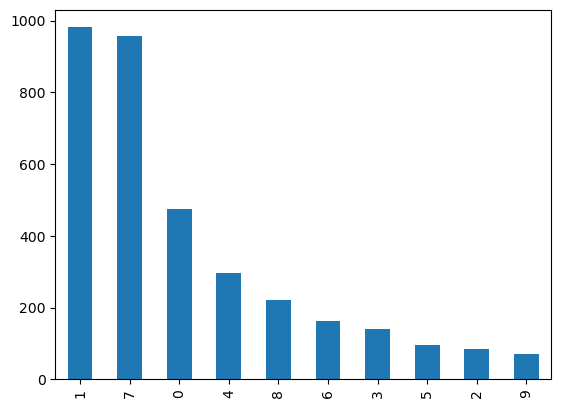

In [40]:
# Print the updated DataFrame
dfTor['neighborhoodNew'].value_counts().plot(kind='bar')

<Axes: >

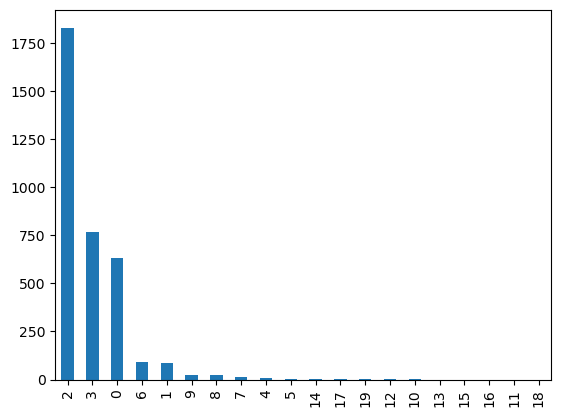

In [41]:
dfTor['property_typeCode'].value_counts().plot(kind='bar')

<Axes: >

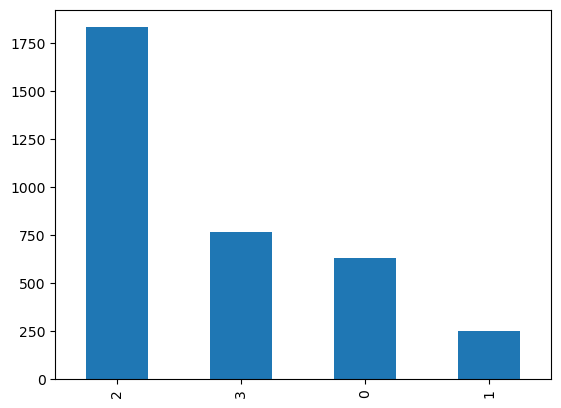

In [42]:
for i in range(4,20):
    dfTor['property_typeCode'] = np.where(dfTor['property_typeCode'] == i, 1, dfTor['property_typeCode'])
dfTor['property_typeCode'].value_counts().plot(kind='bar')

<Axes: >

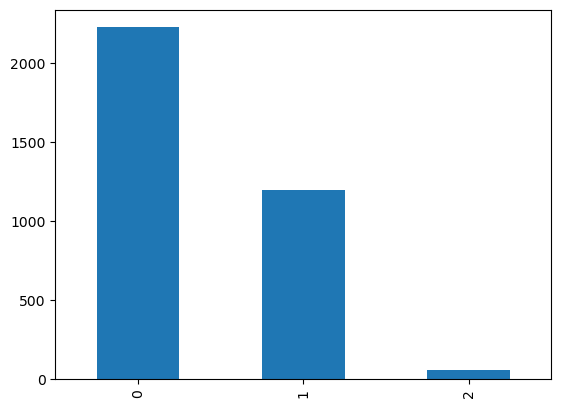

In [43]:
dfTor['room_typeCode'].value_counts().plot(kind='bar')

<Axes: >

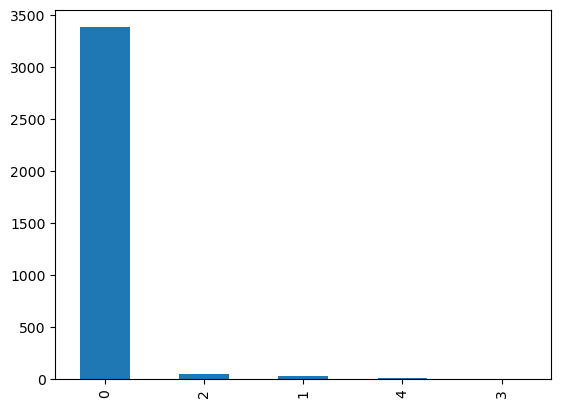

In [44]:
dfTor['bed_typeCode'].value_counts().plot(kind='bar')

<Axes: >

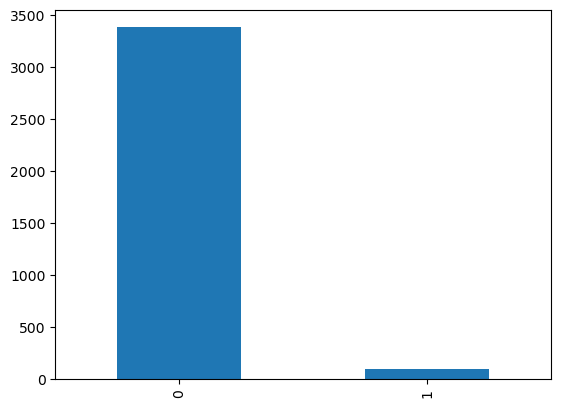

In [45]:
for i in range(1,5):
    dfTor['bed_typeCode'] = np.where(dfTor['bed_typeCode'] == i, 1, dfTor['bed_typeCode'])
dfTor['bed_typeCode'].value_counts().plot(kind='bar')

<Axes: >

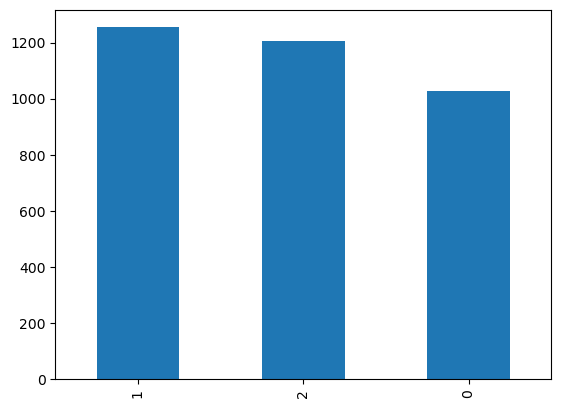

In [46]:
dfTor['cancellation_policyCode'].value_counts().plot(kind='bar')

In [47]:
dfTorNonNum = dfTor.drop(colsNum, axis=1)
dfTorNonNum.head()

,host_verifications,street,amenities,calendar_updated,features,property_typeCode,room_typeCode,bed_typeCode,cancellation_policyCode
0,"[email, phone, reviews, jumio]","Niagara, Toronto, ON M6K 0A1, Canada","[TV, Internet, Wireless Internet, Air conditio...",yesterday,"[Host Has Profile Pic, Host Identity Verified,...",1,0,0,1
1,"[email, phone, reviews]","Riverdale, Toronto, ON M4K 1M6, Canada","[TV, Cable TV, Internet, Wireless Internet, Ai...",5 days ago,"[Host Has Profile Pic, Is Location Exact]",2,0,0,2
2,"[email, phone, reviews, jumio]","Trinity-Bellwoods, Toronto, ON M6J 1L4, Canada","[Wireless Internet, Air conditioning, Kitchen,...",4 days ago,"[Host Has Profile Pic, Host Identity Verified,...",2,0,0,2
3,"[email, phone, google, reviews, jumio, offline...","Trinity-Bellwoods, Toronto, ON M6J 1E4, Canada","[TV, Cable TV, Internet, Wireless Internet, Ai...",4 days ago,"[Host Has Profile Pic, Host Identity Verified,...",2,0,0,0
4,"[email, phone, reviews, jumio]","Dufferin Grove, Toronto, ON M6H 3N5, Canada","[Internet, Wireless Internet, Air conditioning...",yesterday,"[Host Has Profile Pic, Host Identity Verified,...",3,1,0,2


                                host_listings_count  \
host_listings_count                        1.000000   
host_total_listings_count                  1.000000   
accommodates                              -0.001672   
bathrooms                                  0.029038   
bedrooms                                   0.025866   
beds                                       0.020539   
price                                     -0.095769   
security_deposit                          -0.001029   
cleaning_fee                               0.052573   
guests_included                           -0.023365   
extra_people                               0.068780   
minimum_nights                            -0.052410   
maximum_nights                             0.075140   
availability_30                            0.096111   
availability_60                            0.121784   
availability_90                            0.140393   
availability_365                           0.190962   
calculated

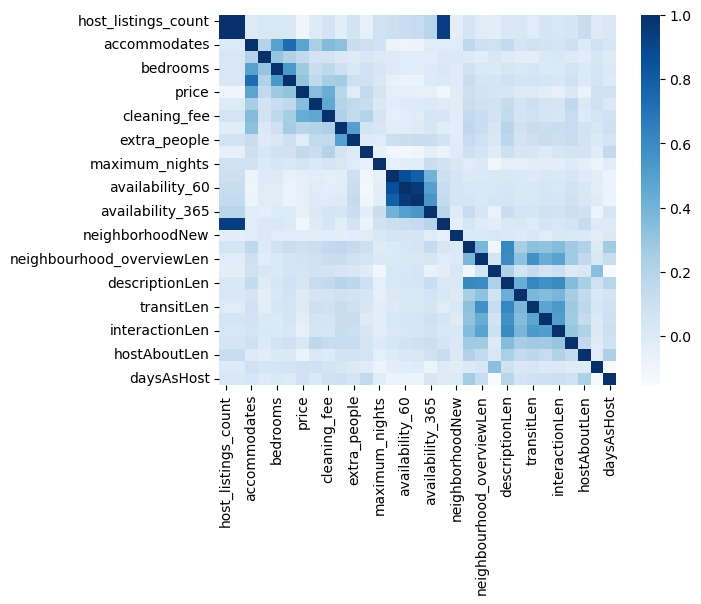

In [48]:
dfNum =dfTor[colsNum]

corr = dfNum.corr()

sb.heatmap(corr, cmap="Blues", annot=False)

print(corr)

In [49]:
#Remove one from pairs of highly correlated
for col1 in corr.columns:
    for col2 in corr.columns:
        correlation_value = corr.loc[col1, col2]
        if abs(correlation_value) > 0.7 and col1!=col2: #show strongly correlated pairs
            print(col1,col2,correlation_value)


host_listings_count host_total_listings_count 1.0
host_listings_count calculated_host_listings_count 0.9350234774203368
host_total_listings_count host_listings_count 1.0
host_total_listings_count calculated_host_listings_count 0.9350234774203368
accommodates beds 0.726488552596244
beds accommodates 0.726488552596244
availability_30 availability_60 0.8665514295566467
availability_30 availability_90 0.7850194604361654
availability_60 availability_30 0.8665514295566467
availability_60 availability_90 0.9521526343530056
availability_90 availability_30 0.7850194604361654
availability_90 availability_60 0.9521526343530056
calculated_host_listings_count host_listings_count 0.9350234774203368
calculated_host_listings_count host_total_listings_count 0.9350234774203368


In [50]:
droppedCols.extend(["host_listings_count","calculated_host_listings_count","availability_90"]) #keep only one value of strongly correlated pairs
dfTor = dfTor.drop(["host_listings_count","calculated_host_listings_count","availability_90"], axis=1)

In [51]:
#Drop List Columns Remaining - may add back later for more investigation

droppedCols.extend(['host_verifications', 'amenities', 'features'])
dfTor = dfTor.drop(['host_verifications', 'amenities', 'features'], axis=1)

droppedCols.extend(['street','calendar_updated'])
dfTor = dfTor.drop(['street','calendar_updated'], axis=1)


In [52]:
print(dfTor.shape)

(3486, 32)


In [53]:
dfTor.head()

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_365,neighborhoodNew,spaceLen,neighbourhood_overviewLen,summaryLen,descriptionLen,notesLen,transitLen,accessLen,interactionLen,houseRulesLen,hostAboutLen,nameLen,daysAsHost,property_typeCode,room_typeCode,bed_typeCode,cancellation_policyCode
0,1.0,2.0,1.0,1.0,1.0,69.0,0.0,99.0,1.0,0.0,1.0,1125.0,3.0,3.0,3.0,7,172.0,179.0,238.0,745.0,0.0,101.0,51.0,0.0,0.0,98.0,32,3332.0,1,0,0,1
1,1.0,2.0,1.0,1.0,2.0,95.0,250.0,100.0,1.0,20.0,5.0,120.0,9.0,33.0,328.0,4,522.0,225.0,243.0,1000.0,73.0,356.0,118.0,83.0,103.0,490.0,29,3526.0,2,0,0,2
2,2.0,2.0,1.0,1.0,1.0,80.0,0.0,75.0,2.0,35.0,3.0,150.0,7.0,14.0,289.0,7,0.0,0.0,452.0,452.0,0.0,0.0,0.0,0.0,0.0,124.0,41,3526.0,2,0,0,2
3,1.0,3.0,1.0,1.0,1.0,149.0,399.0,70.0,2.0,25.0,3.0,1125.0,14.0,41.0,346.0,7,263.0,204.0,495.0,1000.0,0.0,266.0,74.0,105.0,187.0,55.0,49,2317.0,2,0,0,0
4,1.0,1.0,1.0,1.0,1.0,59.0,140.0,15.0,1.0,0.0,3.0,21.0,14.0,37.0,141.0,0,73.0,348.0,368.0,1000.0,0.0,109.0,187.0,189.0,160.0,239.0,41,3701.0,3,1,0,2


Cross Validation

In [54]:
X = dfTor.drop(['price'], axis=1)
y = dfTor['price']

In [55]:
def perform_cross_validation(name, X, y, model, cv=5, scoring='neg_mean_squared_error'):
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    # Here, we use 'neg_mean_squared_error' as the scoring metric
    
    print(name, "-", cv)
    # Print the mean squared error for each fold
    print("Cross-validation scores:", scores)
    # Print the mean and standard deviation of the scores
    print("Mean squared error:", -scores.mean())
    print("Standard deviation:", scores.std())
    print("")
    # Return the mean squared error for each fold
    return -scores  # Negate the scores to get positive MSE values


Model 1 - Linear Regression

In [56]:
# Create a regression model (Linear Regression, for example)
reg = linear_model.LinearRegression()

#Cross Validation with different # of Folds
for i in range(3, 11):
    scores1 = perform_cross_validation("Linear Regression", X, y, reg, cv=i, scoring='neg_mean_squared_error')

Linear Regression - 3
Cross-validation scores: [ -970.06099315  -985.22762984 -1000.43162537]
Mean squared error: 985.2400827883635
Standard deviation: 12.398761812976838

Linear Regression - 4
Cross-validation scores: [ -933.50088266 -1027.48297815 -1015.76232373  -951.53741193]
Mean squared error: 982.0708991172746
Standard deviation: 40.276262715193546



Linear Regression - 5
Cross-validation scores: [ -934.98981793  -989.52861058 -1041.01255669 -1007.7021398
  -932.67065102]
Mean squared error: 981.180755203143
Standard deviation: 42.046992505162734

Linear Regression - 6
Cross-validation scores: [ -987.44107713  -941.16770034  -998.91057922  -953.01838788
 -1085.29582596  -909.16614106]
Mean squared error: 979.1666185980248
Standard deviation: 55.900825747608366

Linear Regression - 7
Cross-validation scores: [ -960.54228707  -933.25451913  -988.36702214 -1090.26023333
  -922.23631607 -1087.75277681  -906.86380201]
Mean squared error: 984.1824223646369
Standard deviation: 70.67513973536157

Linear Regression - 8
Cross-validation scores: [ -979.43360534  -884.71069858 -1022.16576127 -1032.63191124
 -1008.14226904 -1023.63885803  -941.23912688  -964.26707817]
Mean squared error: 982.0286635690795
Standard deviation: 47.48918931741136

Linear Regression - 9
Cross-validation scores: [ -922.15311205  -961.78805795 -1010.89888589  -960.110

Model 2 - Random Forest Regressor

In [57]:
# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

#Cross Validation with different # of Folds
for i in range(3, 11):
    scores2 = perform_cross_validation("Random Forest", X, y, rf_regressor, cv=i, scoring='neg_mean_squared_error')

Random Forest - 3
Cross-validation scores: [-898.76174716 -908.77037031 -906.33076497]
Mean squared error: 904.6209608146874
Standard deviation: 4.2611193393486895

Random Forest - 4
Cross-validation scores: [-856.1168258  -932.36816606 -892.35443927 -864.34957382]
Mean squared error: 886.2972512365506
Standard deviation: 29.798394848689092

Random Forest - 5
Cross-validation scores: [-817.45531504 -926.68080043 -926.14725007 -906.44573788 -837.44599641]
Mean squared error: 882.8350199669891
Standard deviation: 46.23967347726076

Random Forest - 6
Cross-validation scores: [-857.79578778 -863.85738606 -931.69161652 -834.61513287 -999.86229466
 -816.44125456]
Mean squared error: 884.0439120768789
Standard deviation: 62.97351938533133

Random Forest - 7
Cross-validation scores: [ -843.9548751   -848.12569558  -887.5456747   -963.89603112
  -796.01586265 -1011.98961506  -812.56808695]
Mean squared error: 880.5851201663799
Standard deviation: 74.0944992222102

Random Forest - 8
Cross-valida

Model 3 - Decision Tree

In [58]:
# Create a decision tree regressor
decision_tree = DecisionTreeRegressor()

#Cross Validation with different # of Folds for Decision Tree
for i in range(3, 11):
    scores3 = perform_cross_validation("Decision Tree", X, y, decision_tree, cv=i, scoring='neg_mean_squared_error')

Decision Tree - 3
Cross-validation scores: [-1850.86833046 -1646.96213425 -1844.34681583]
Mean squared error: 1780.7257601835915
Standard deviation: 94.62263032764935

Decision Tree - 4
Cross-validation scores: [-1476.05275229 -1949.49197248 -1698.57405281 -1894.18828932]
Mean squared error: 1754.5767667265295
Standard deviation: 185.87310540790642

Decision Tree - 5
Cross-validation scores: [-1578.52292264 -1845.69153515 -1593.69440459 -1664.31133429
 -1878.47632712]
Mean squared error: 1712.1393047567758
Standard deviation: 126.23331569426749

Decision Tree - 6
Cross-validation scores: [-1653.56454389 -1667.0757315  -1837.20137694 -1766.14802065
 -1847.75215146 -1635.14113597]
Mean squared error: 1734.4804934021802
Standard deviation: 86.93290656553972

Decision Tree - 7
Cross-validation scores: [-1591.25301205 -1693.47791165 -1861.74297189 -1754.6686747
 -1693.65863454 -1835.79518072 -1808.70682731]
Mean squared error: 1748.4718875502008
Standard deviation: 88.5348592539268

Decisio

Feature Selection

In [70]:
allScores = {}

for i in range(1, 35):
    # Perform Recursive Feature Elimination
    print(i, "Features")
    rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=i)  # Select the desired number of features

    # Fit the RFE model to the data
    rfe.fit(X, y)

    # Get the selected features
    selected_features = rfe.support_
    feature_ranking = rfe.ranking_

    features = []

    for feature, support, rank in zip(X.columns, selected_features, feature_ranking):
        if support:
            features.append(feature) #create list of selected features
    
    print("Features:",features)
    scores2 = perform_cross_validation("Random Forest", X[features], y,  RandomForestRegressor(n_estimators=100, random_state=42), cv=4, scoring='neg_mean_squared_error')

    mse = scores2.mean()
    std = scores2.std()

    allScores[i] = [features, mse, std]

1 Features
Features: ['daysAsHost']
Random Forest - 4
Cross-validation scores: [-2627.49353546 -2679.03452518 -2551.16356312 -2371.05525375]
Mean squared error: 2557.1867193782373
Standard deviation: 116.69526241166695

2 Features
Features: ['daysAsHost', 'room_typeCode']
Random Forest - 4
Cross-validation scores: [-1654.7711898  -1803.00182219 -1811.61008786 -1697.92557495]
Mean squared error: 1741.8271686980809
Standard deviation: 67.30172254900751

3 Features
Features: ['summaryLen', 'daysAsHost', 'room_typeCode']
Random Forest - 4
Cross-validation scores: [-1403.44267514 -1484.44639626 -1577.69414757 -1380.77066509]
Mean squared error: 1461.58847101516
Standard deviation: 77.32312753500354

4 Features
Features: ['availability_365', 'summaryLen', 'daysAsHost', 'room_typeCode']
Random Forest - 4
Cross-validation scores: [-1344.35437999 -1432.25857954 -1440.9063761  -1331.95170765]
Mean squared error: 1387.3677608213034
Standard deviation: 49.504188741497416

5 Features
Features: ['cl

In [78]:
from array import array

allMSEs = []
for i in allScores:
    allMSEs.append(allScores[i][1])

allSTDs = []
for i in allScores:
    allSTDs.append(allScores[i][2])


def calculate_combined_score(mse_scores, sd_scores, mse_weight, sd_weight):
    # Normalize scores
    normalized_mse = (mse_scores - np.min(mse_scores)) / (np.max(mse_scores) - np.min(mse_scores))
    normalized_sd = (sd_scores - np.min(sd_scores)) / (np.max(sd_scores) - np.min(sd_scores))
    
    # Calculate combined score
    combined_score = mse_weight * normalized_mse + sd_weight * normalized_sd
    return combined_score

combinedScore = calculate_combined_score(allMSEs, allSTDs, mse_weight=0.7, sd_weight=0.3)

In [79]:
i = 1
minScore = 2
bestNumFeatures = 0
bestFeatures = []
for score in combinedScore:
    if score < minScore:
        minScore = score
        bestNumFeatures = i
        bestFeatures = allScores[i][0]
    elif score == minScore:
        print("TIE")
    i += 1
print("Best number of features:", bestNumFeatures)
print("Features:", features)

Best number of features: 24
Features: ['host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_365', 'neighborhoodNew', 'spaceLen', 'neighbourhood_overviewLen', 'summaryLen', 'descriptionLen', 'notesLen', 'transitLen', 'accessLen', 'interactionLen', 'houseRulesLen', 'hostAboutLen', 'nameLen', 'daysAsHost', 'property_typeCode', 'room_typeCode', 'bed_typeCode', 'cancellation_policyCode']


Use the Model to Predict Values and Evaluate Results

In [80]:
predictX = dfTor[features]
predicty = dfTor["price"]

predicted = cross_val_predict(rf_regressor, predictX, predicty, cv=3)
dfTor["predicted"] = predicted

In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate the model
mae = mean_absolute_error(dfTor['price'], dfTor['predicted'])
mse = mean_squared_error(dfTor['price'], dfTor['predicted'])
rmse = mean_squared_error(dfTor['price'], dfTor['predicted'], squared=False)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 22.618955823293174
Mean Squared Error (MSE): 904.6209608146874
Root Mean Squared Error (RMSE): 30.076917408781895


In [82]:
# Calculate the price difference percentage
dfTor['PriceDifference'] = dfTor['price'] - dfTor['predicted']

# Add a new column to indicate if the price is overpriced, underpriced, or accurately priced
dfTor['PriceStatusMAE'] = pd.cut(dfTor['PriceDifference'], 
                              bins=[-float('inf'), -mae, mae, float('inf')], 
                              labels=['Underpriced', 'Accurately Priced', 'Overpriced'])

# Add a new column to indicate if the price is overpriced, underpriced, or accurately priced
dfTor['PriceStatusRMSE'] = pd.cut(dfTor['PriceDifference'], 
                              bins=[-float('inf'), -rmse, rmse, float('inf')], 
                              labels=['Underpriced', 'Accurately Priced', 'Overpriced'])
# Print the updated dataframe
print(dfTor[["price","predicted","PriceDifference","PriceStatusMAE","PriceStatusRMSE"]])




      price  predicted  PriceDifference     PriceStatusMAE    PriceStatusRMSE
0      69.0     120.16           -51.16        Underpriced        Underpriced
1      95.0     129.81           -34.81        Underpriced        Underpriced
2      80.0     118.52           -38.52        Underpriced        Underpriced
3     149.0     152.70            -3.70  Accurately Priced  Accurately Priced
4      59.0      49.54             9.46  Accurately Priced  Accurately Priced
5      69.0      90.56           -21.56  Accurately Priced  Accurately Priced
6      86.0      84.99             1.01  Accurately Priced  Accurately Priced
7      99.0     115.54           -16.54  Accurately Priced  Accurately Priced
8     200.0     130.75            69.25         Overpriced         Overpriced
9      55.0      61.63            -6.63  Accurately Priced  Accurately Priced
10    155.0     135.14            19.86  Accurately Priced  Accurately Priced
11    104.0     118.22           -14.22  Accurately Priced  Accu

<Axes: >

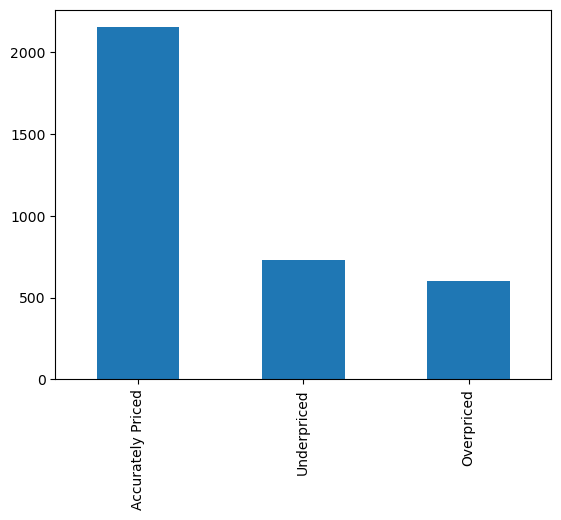

In [83]:
dfTor['PriceStatusMAE'].value_counts().plot(kind='bar')

<Axes: >

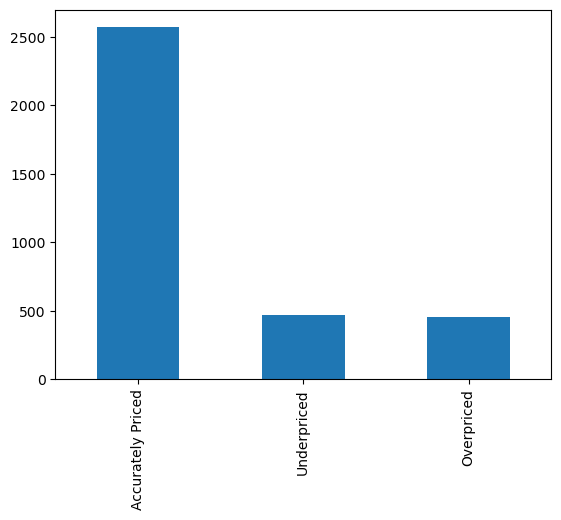

In [84]:
dfTor['PriceStatusRMSE'].value_counts().plot(kind='bar')